# 1. Import Packages and Dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast,RandomTranslation,RandomBrightness
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import Xception

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the dataset directory after extraction
directory = '/content/drive/MyDrive/materials dataset'

# Proceed with your dataset loading code
BATCH_SIZE = 32
IMG_SIZE = (384, 384)

# 70% Training data
train_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.3,
    subset='training',
    seed=42
)

# Split the 30% into validation and test sets, 15% each
validation_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.3,
    subset='validation',
    seed=42
)

# Creating a test dataset from the validation dataset by splitting in half
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

class_names = train_dataset.class_names
print(f"Class names: {class_names}")


Found 22907 files belonging to 16 classes.
Using 16035 files for training.
Found 22907 files belonging to 16 classes.
Using 6872 files for validation.
Class names: ['aluminum_food_can', 'aluminum_soda_can', 'cardboard', 'fabric', 'glass_bottle', 'glass_jar', 'paper', 'plain_cup', 'plastic_bag', 'plastic_bottle', 'plastic_cup', 'plastic_cutlery', 'plastic_detergent_bottle', 'plastic_food_container', 'plastic_straws', 'styrofoam_food_containers']


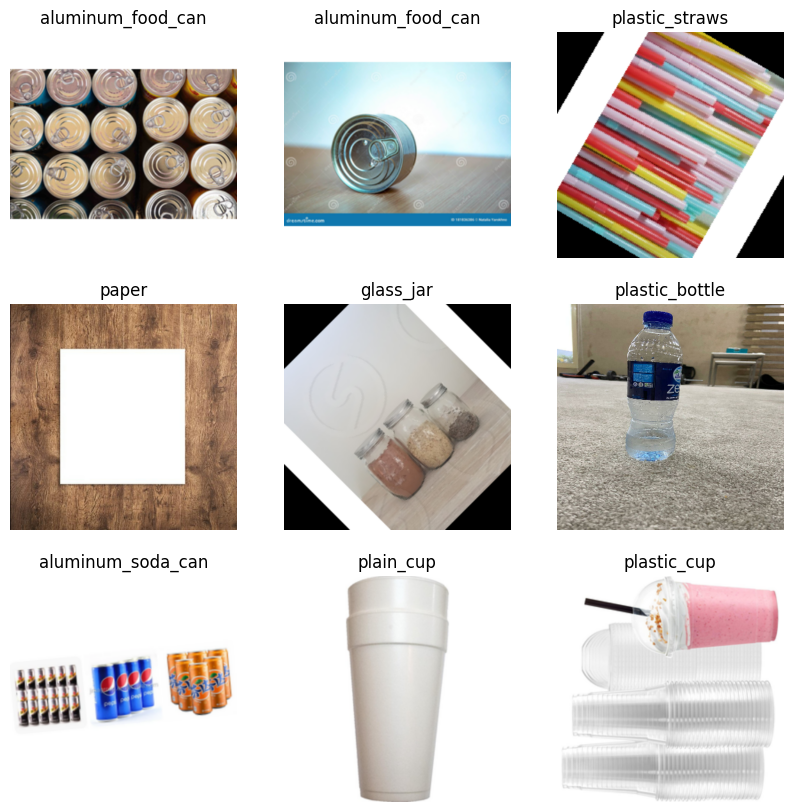

In [ ]:
# Verify the dataset structure and plot some examples
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = tf.argmax(labels[i]).numpy()  # Get the index of the highest value (class)
        plt.title(class_names[label_index])
        plt.axis("off")

plt.show()

# 2. Preprocess and Augment Training Data

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

### data_augmenter
a function for data augmentation.

In [ ]:

def data_augmenter():
    '''
    Returns:
        tf.keras.Sequential
    '''

    data_augmentation = tf.keras.Sequential([
        RandomFlip('horizontal'),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomContrast(0.2)
    ])

    return data_augmentation

### Sample of the augmentation

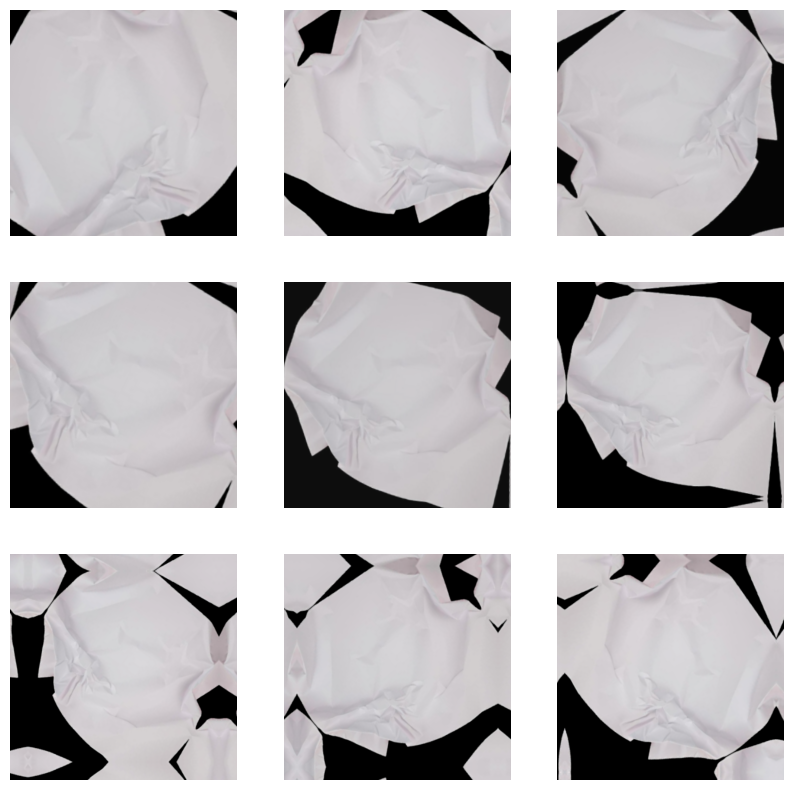

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# 3.Models implementation

## 3.1 ResNet50 Model

we're using a pre-trained model that was trained on the normalization values [-1,1]

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

### 3.1.1 Layer Freezing with the Functional API

In [ ]:
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
def model(image_shape=IMG_SIZE, data_augmentation=data_augmenter(),num_classes=num_classes,dropout_rate=0.4):
    '''
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
        num_classes -- number of category classes
        dropout_rate -- droupout_rate for the classifaction layer
    Returns:
        tf.keras.model
    '''

    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.ResNet50(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet

    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer
    inputs = tf.keras.Input(shape=input_shape)

    # apply data augmentation to the inputs
    x = data_augmentation(inputs)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # add the new  classification layers
    # global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)
    # dropout layer to avoid overfitting
    x = tfl.Dropout(rate=dropout_rate)(x)
    # a prediction layer with num_classes neurons with l2 regularizer
    outputs = tfl.Dense(units=num_classes,kernel_regularizer=l2(0.01))(x)


    model = tf.keras.Model(inputs, outputs)

    return model


Number of classes: 16


In [ ]:
model2 = model(IMG_SIZE, data_augmentation)

In [ ]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# import pickle

# class SaveHistoryCallback(tf.keras.callbacks.Callback):
#     def __init__(self, filename='training_history.pkl'):
#         self.filename = filename

#     def on_epoch_end(self, epoch, logs=None):
#         try:
#             # Append history to file
#             with open(self.filename, 'ab') as f:
#                 pickle.dump(logs, f)
#         except Exception as e:
#             print(f"Error saving history: {e}")

# history_saver = SaveHistoryCallback()
# initial_epochs = 50  # Set a high number of epochs to allow early stopping to trigger
# history = model2.fit(
#     train_dataset,
#     validation_data=validation_dataset,
#     epochs=initial_epochs,
#     callbacks=[history_saver]
# )

# # Extract training history
# train_acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# epochs = range(1, len(train_acc) + 1)

# # Plot training and validation accuracy
# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_acc, label='Training Accuracy')
# plt.plot(epochs, val_acc, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

Epoch 1/5
187/502 ━━━━━━━━━━━━━━━━━━━━ 7:32 1s/step - accuracy: 0.4024 - loss: 2.3761

2024-11-22 14:14:23.150518: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


315/502 ━━━━━━━━━━━━━━━━━━━━ 4:32 1s/step - accuracy: 0.4823 - loss: 2.0678

2024-11-22 14:17:34.105929: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 917s 2s/step - accuracy: 0.5480 - loss: 1.8191 - val_accuracy: 0.8668 - val_loss: 0.6768
Epoch 2/5
200/502 ━━━━━━━━━━━━━━━━━━━━ 7:41 2s/step - accuracy: 0.7965 - loss: 0.8679

2024-11-22 14:30:00.550397: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


320/502 ━━━━━━━━━━━━━━━━━━━━ 4:39 2s/step - accuracy: 0.7956 - loss: 0.8691

2024-11-22 14:33:05.320251: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 925s 2s/step - accuracy: 0.7953 - loss: 0.8686 - val_accuracy: 0.8753 - val_loss: 0.5987
Epoch 3/5
202/502 ━━━━━━━━━━━━━━━━━━━━ 7:35 2s/step - accuracy: 0.8018 - loss: 0.8117

2024-11-22 14:46:23.194618: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


308/502 ━━━━━━━━━━━━━━━━━━━━ 4:56 2s/step - accuracy: 0.8024 - loss: 0.8104

2024-11-22 14:49:06.986264: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 980s 2s/step - accuracy: 0.8030 - loss: 0.8097 - val_accuracy: 0.8709 - val_loss: 0.6041
Epoch 4/5
200/502 ━━━━━━━━━━━━━━━━━━━━ 7:40 2s/step - accuracy: 0.8068 - loss: 0.7680

2024-11-22 15:02:43.617522: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


324/502 ━━━━━━━━━━━━━━━━━━━━ 4:32 2s/step - accuracy: 0.8102 - loss: 0.7687

2024-11-22 15:05:54.297861: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8116 - loss: 0.7710

2024-11-22 15:10:32.268322: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19269632 bytes after encountering the first element of size 19269632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


502/502 ━━━━━━━━━━━━━━━━━━━━ 982s 2s/step - accuracy: 0.8116 - loss: 0.7710 - val_accuracy: 0.8715 - val_loss: 0.6170
Epoch 5/5
207/502 ━━━━━━━━━━━━━━━━━━━━ 7:08 1s/step - accuracy: 0.8162 - loss: 0.7820

2024-11-22 15:18:01.832407: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


317/502 ━━━━━━━━━━━━━━━━━━━━ 4:33 1s/step - accuracy: 0.8169 - loss: 0.7783

2024-11-22 15:20:49.315864: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 903s 2s/step - accuracy: 0.8166 - loss: 0.7775 - val_accuracy: 0.8738 - val_loss: 0.5899


### 3.1.2 Plot the training and validation accuracy:

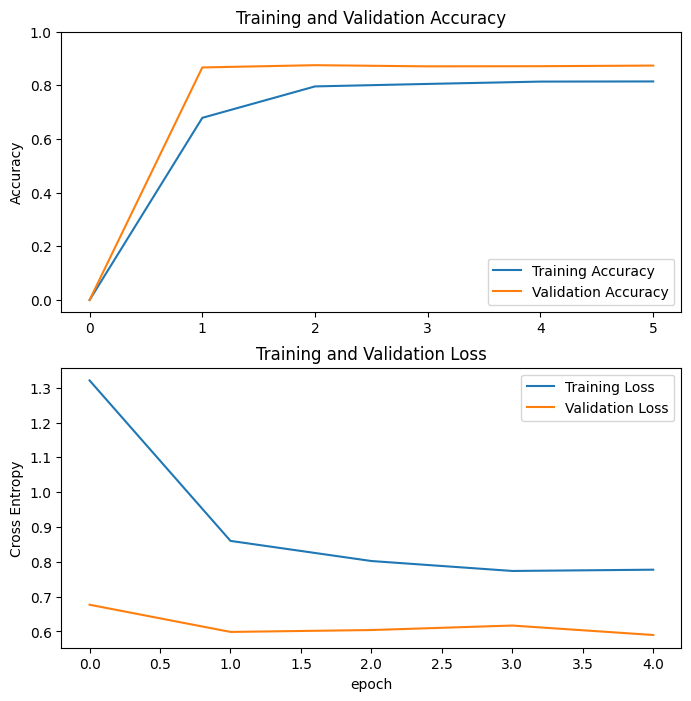

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 3.1.3 Confusion Matrix and Classification Report


In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Step 1: Evaluate the model on test data
# test_loss, test_accuracy = model2.evaluate(test_dataset)
# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")

# # Step 2: Generate predictions on the test dataset for a detailed report
# y_true = []
# y_pred = []

# # Collect true labels and predicted labels
# for images, labels in test_dataset:
#     preds = model2.predict(images)
#     y_pred.extend(preds.argmax(axis=-1))  # Convert predicted logits to class indices
#     y_true.extend(labels.numpy().argmax(axis=-1))

# # Print classification report
# print(classification_report(y_true, y_pred, target_names=class_names))

# # Step 3: Generate confusion matrix
# conf_matrix = confusion_matrix(y_true, y_pred)

# # Visualize confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

## 3.2 VGG19 Model

In [ ]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE, include_top=True,weights='imagenet')

### 3.2.1 Layer Freezing with the Functional API

---



In [ ]:
def vgg19_model(image_shape, data_augmentation, num_classes, dropout_rate=0.4):


    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.ResNet50(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet

    base_model.trainable = False

    # Define the inputs
    inputs = tf.keras.Input(shape=input_shape)

    # Apply data augmentation
    x = data_augmentation(inputs)

    # Preprocess the input for VGG19
    x = preprocess_input(x)

    # Pass through the base model
    x = base_model(x, training=False)

    # Add custom classification layers
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(rate=dropout_rate)(x)
    outputs = tfl.Dense(units=num_classes,kernel_regularizer=l2(0.01))(x)

    # Build and return the model
    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
model2vgg = vgg19_model(IMG_SIZE, data_augmentation, num_classes)

In [ ]:
base_learning_rate = 0.001
model2vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 5
history = model2vgg.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5


196/502 ━━━━━━━━━━━━━━━━━━━━ 7:01 1s/step - accuracy: 0.4147 - loss: 2.3537

2024-11-22 15:32:51.587863: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


317/502 ━━━━━━━━━━━━━━━━━━━━ 4:16 1s/step - accuracy: 0.4853 - loss: 2.0698

2024-11-22 15:35:40.452845: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 849s 2s/step - accuracy: 0.5474 - loss: 1.8237 - val_accuracy: 0.8631 - val_loss: 0.6716
Epoch 2/5
207/502 ━━━━━━━━━━━━━━━━━━━━ 6:45 1s/step - accuracy: 0.7871 - loss: 0.8949

2024-11-22 15:47:04.715023: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


320/502 ━━━━━━━━━━━━━━━━━━━━ 4:11 1s/step - accuracy: 0.7895 - loss: 0.8879

2024-11-22 15:49:42.235387: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 833s 2s/step - accuracy: 0.7916 - loss: 0.8805 - val_accuracy: 0.8721 - val_loss: 0.6117
Epoch 3/5
231/502 ━━━━━━━━━━━━━━━━━━━━ 6:12 1s/step - accuracy: 0.8015 - loss: 0.8063

2024-11-22 16:01:31.002036: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


348/502 ━━━━━━━━━━━━━━━━━━━━ 3:32 1s/step - accuracy: 0.8033 - loss: 0.8032

2024-11-22 16:04:14.495243: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 834s 2s/step - accuracy: 0.8053 - loss: 0.8001 - val_accuracy: 0.8703 - val_loss: 0.6088
Epoch 4/5
192/502 ━━━━━━━━━━━━━━━━━━━━ 7:06 1s/step - accuracy: 0.8119 - loss: 0.7883

2024-11-22 16:15:00.159195: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


312/502 ━━━━━━━━━━━━━━━━━━━━ 4:22 1s/step - accuracy: 0.8127 - loss: 0.7852

2024-11-22 16:17:47.895892: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 864s 2s/step - accuracy: 0.8135 - loss: 0.7831 - val_accuracy: 0.8750 - val_loss: 0.5815
Epoch 5/5
191/502 ━━━━━━━━━━━━━━━━━━━━ 6:53 1s/step - accuracy: 0.8133 - loss: 0.7668

2024-11-22 16:28:45.011445: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


306/502 ━━━━━━━━━━━━━━━━━━━━ 4:27 1s/step - accuracy: 0.8132 - loss: 0.7700

2024-11-22 16:31:28.263201: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 836s 2s/step - accuracy: 0.8137 - loss: 0.7732 - val_accuracy: 0.8732 - val_loss: 0.5793


### 3.2.2 Plot the training and validation accuracy:

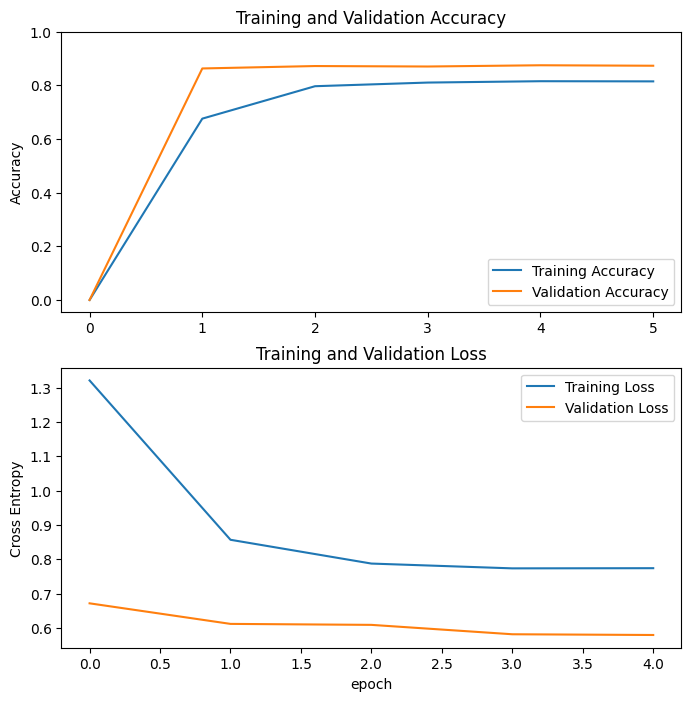

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 3.2.3 Confusion Matrix and Classification Report


In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Step 1: Evaluate the model on test data
# test_loss, test_accuracy = model2vgg.evaluate(test_dataset)
# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")

# # Step 2: Generate predictions on the test dataset for a detailed report
# y_true = []
# y_pred = []

# # Collect true labels and predicted labels
# for images, labels in test_dataset:
#     preds = model2vgg.predict(images)
#     y_pred.extend(preds.argmax(axis=-1))  # Convert predicted logits to class indices
#     y_true.extend(labels.numpy().argmax(axis=-1))

# # Print classification report
# print(classification_report(y_true, y_pred, target_names=class_names))

# # Step 3: Generate confusion matrix
# conf_matrix = confusion_matrix(y_true, y_pred)

# # Visualize confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

## 3.3 Xception Model

In [ ]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [ ]:
IMG_SIZE = (299, 299)
input_shape = IMG_SIZE + (3,)
base_model = tf.keras.applications.Xception(input_shape=input_shape, include_top=True,weights='imagenet')

### 3.3.1 Layer Freezing with the Functional API

In [ ]:
def xception_model(image_shape, data_augmentation, num_classes, dropout_rate=0.4):


    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.Xception(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet

    base_model.trainable = False

    # Define the inputs
    inputs = tf.keras.Input(shape=input_shape)

    # Apply data augmentation
    x = data_augmentation(inputs)

    # Preprocess the input for Xception
    x = preprocess_input(x)

    # Pass through the base model
    x = base_model(x, training=False)

    # Add custom classification layers
    x = tfl.GlobalAveragePooling2D()(x)  # Summarize feature maps
    x = tfl.Dropout(rate=dropout_rate)(x)  # Regularization
    outputs = tfl.Dense(units=num_classes, kernel_regularizer=l2(0.01))(x)  # Output layer

    # Build and return the model
    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
IMG_SIZE=(224,224)
model2x = xception_model(IMG_SIZE, data_augmentation, num_classes)

In [ ]:
base_learning_rate = 0.001
model2x.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 5
history = model2x.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
192/502 ━━━━━━━━━━━━━━━━━━━━ 8:21 2s/step - accuracy: 0.4233 - loss: 2.2499

2024-11-22 16:43:53.063631: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


311/502 ━━━━━━━━━━━━━━━━━━━━ 5:10 2s/step - accuracy: 0.4924 - loss: 2.0337

2024-11-22 16:47:08.869145: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 999s 2s/step - accuracy: 0.5532 - loss: 1.8367 - val_accuracy: 0.8013 - val_loss: 0.9869
Epoch 2/5
216/502 ━━━━━━━━━━━━━━━━━━━━ 7:44 2s/step - accuracy: 0.7460 - loss: 1.1439

2024-11-22 17:01:02.292304: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


317/502 ━━━━━━━━━━━━━━━━━━━━ 5:01 2s/step - accuracy: 0.7479 - loss: 1.1374

2024-11-22 17:03:48.445406: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 991s 2s/step - accuracy: 0.7501 - loss: 1.1308 - val_accuracy: 0.8100 - val_loss: 0.9376
Epoch 3/5
207/502 ━━━━━━━━━━━━━━━━━━━━ 8:15 2s/step - accuracy: 0.7642 - loss: 1.0760

2024-11-22 17:17:29.266975: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


313/502 ━━━━━━━━━━━━━━━━━━━━ 5:14 2s/step - accuracy: 0.7640 - loss: 1.0776

2024-11-22 17:20:22.145795: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 999s 2s/step - accuracy: 0.7639 - loss: 1.0797 - val_accuracy: 0.8123 - val_loss: 0.9302
Epoch 4/5
186/502 ━━━━━━━━━━━━━━━━━━━━ 8:36 2s/step - accuracy: 0.7727 - loss: 1.0693

2024-11-22 17:33:25.163453: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


312/502 ━━━━━━━━━━━━━━━━━━━━ 5:10 2s/step - accuracy: 0.7713 - loss: 1.0712

2024-11-22 17:36:51.763890: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 990s 2s/step - accuracy: 0.7697 - loss: 1.0736 - val_accuracy: 0.8167 - val_loss: 0.9278
Epoch 5/5
200/502 ━━━━━━━━━━━━━━━━━━━━ 8:12 2s/step - accuracy: 0.7688 - loss: 1.0795

2024-11-22 17:50:17.502632: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


312/502 ━━━━━━━━━━━━━━━━━━━━ 4:37 1s/step - accuracy: 0.7662 - loss: 1.0788

2024-11-22 17:52:27.740499: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 863s 2s/step - accuracy: 0.7652 - loss: 1.0783 - val_accuracy: 0.8285 - val_loss: 0.9118


### 3.3.2 Plot the training and validation accuracy:

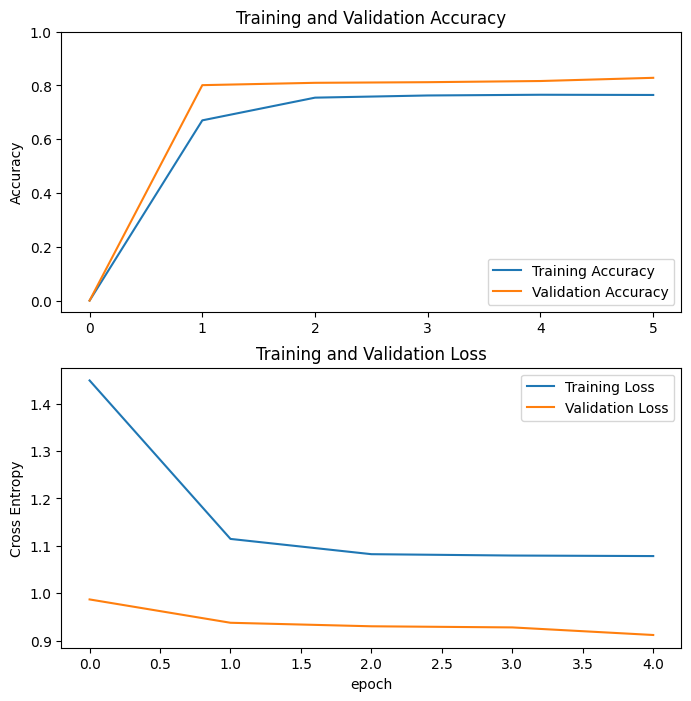

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 3.3.3 Confusion Matrix and Classification Report


---



In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Step 1: Evaluate the model on test data
# test_loss, test_accuracy = model2x.evaluate(test_dataset)
# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")

# # Step 2: Generate predictions on the test dataset for a detailed report
# y_true = []
# y_pred = []

# # Collect true labels and predicted labels
# for images, labels in test_dataset:
#     preds = model2x.predict(images)
#     y_pred.extend(preds.argmax(axis=-1))  # Convert predicted logits to class indices
#     y_true.extend(labels.numpy().argmax(axis=-1))

# # Print classification report
# print(classification_report(y_true, y_pred, target_names=class_names))

# # Step 3: Generate confusion matrix
# conf_matrix = confusion_matrix(y_true, y_pred)

# # Visualize confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

### EfficientB0

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.regularizers import l2

preprocess_input = tf.keras.applications.efficientnet.preprocess_input
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

def model(image_shape=IMG_SIZE, data_augmentation=data_augmenter(), num_classes=num_classes, dropout_rate=0.2):
    '''
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
        num_classes -- number of category classes
        dropout_rate -- dropout rate for the classification layer
    Returns:
        tf.keras.Model
    '''

    input_shape = image_shape + (3,)

    # Load EfficientNetB0 as the base model
    base_model = EfficientNetB0(input_shape=input_shape,
                                include_top=False,  # Exclude top classification layer
                                weights='imagenet')  # Use pretrained ImageNet weights

    # Freeze the base model
    base_model.trainable = False

    # Create the input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Apply data augmentation to the inputs
    x = data_augmentation(inputs)

    # Preprocess the data using the same weights the model was trained on
    x = preprocess_input(x)

    # Pass the preprocessed inputs through the base model
    x = base_model(x, training=False)

    # Add new classification layers
    x = GlobalAveragePooling2D()(x)  # Global Average Pooling to summarize info in each channel
    x = Dropout(rate=dropout_rate)(x)  # Dropout layer to reduce overfitting
    outputs = Dense(units=num_classes, kernel_regularizer=l2(0.01))(x)  # Prediction layer

    # Define the final model
    model = tf.keras.Model(inputs, outputs)

    return model

# Instantiate the model with EfficientNetB0
model2B0 = model(IMG_SIZE, data_augmentation)

# Use a smaller learning rate suitable for transfer learning
base_learning_rate = 0.001
model2B0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
initial_epochs = 10
history = model2B0.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)


Number of classes: 16
Epoch 1/10
205/502 ━━━━━━━━━━━━━━━━━━━━ 1:35 320ms/step - accuracy: 0.4691 - loss: 2.1485

2024-11-26 02:51:47.488678: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


315/502 ━━━━━━━━━━━━━━━━━━━━ 58s 313ms/step - accuracy: 0.5359 - loss: 1.9422

2024-11-26 02:52:20.337259: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 191s 363ms/step - accuracy: 0.5993 - loss: 1.7356 - val_accuracy: 0.8619 - val_loss: 0.8191
Epoch 2/10
200/502 ━━━━━━━━━━━━━━━━━━━━ 1:36 318ms/step - accuracy: 0.8135 - loss: 0.9776

2024-11-26 02:54:47.804558: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


324/502 ━━━━━━━━━━━━━━━━━━━━ 59s 334ms/step - accuracy: 0.8142 - loss: 0.9759

2024-11-26 02:55:32.320793: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 204s 405ms/step - accuracy: 0.8150 - loss: 0.9726 - val_accuracy: 0.8761 - val_loss: 0.7690
Epoch 3/10
188/502 ━━━━━━━━━━━━━━━━━━━━ 1:51 354ms/step - accuracy: 0.8201 - loss: 0.9368

2024-11-26 02:58:14.908966: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


316/502 ━━━━━━━━━━━━━━━━━━━━ 1:06 356ms/step - accuracy: 0.8210 - loss: 0.9370

2024-11-26 02:59:00.664295: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 209s 414ms/step - accuracy: 0.8211 - loss: 0.9385 - val_accuracy: 0.8683 - val_loss: 0.7702
Epoch 4/10
188/502 ━━━━━━━━━━━━━━━━━━━━ 1:50 353ms/step - accuracy: 0.8197 - loss: 0.9418

2024-11-26 03:01:42.693426: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


308/502 ━━━━━━━━━━━━━━━━━━━━ 1:05 337ms/step - accuracy: 0.8218 - loss: 0.9369

2024-11-26 03:02:20.094102: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 187s 372ms/step - accuracy: 0.8228 - loss: 0.9348 - val_accuracy: 0.8735 - val_loss: 0.7607
Epoch 5/10
213/502 ━━━━━━━━━━━━━━━━━━━━ 1:24 293ms/step - accuracy: 0.8211 - loss: 0.9312

2024-11-26 03:04:45.339356: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


316/502 ━━━━━━━━━━━━━━━━━━━━ 54s 295ms/step - accuracy: 0.8231 - loss: 0.9294

2024-11-26 03:05:16.083092: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 174s 346ms/step - accuracy: 0.8241 - loss: 0.9298 - val_accuracy: 0.8744 - val_loss: 0.7651
Epoch 6/10
195/502 ━━━━━━━━━━━━━━━━━━━━ 1:30 295ms/step - accuracy: 0.8205 - loss: 0.9347

2024-11-26 03:07:34.285466: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


319/502 ━━━━━━━━━━━━━━━━━━━━ 53s 292ms/step - accuracy: 0.8233 - loss: 0.9307

2024-11-26 03:08:10.120297: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 173s 346ms/step - accuracy: 0.8249 - loss: 0.9299 - val_accuracy: 0.8779 - val_loss: 0.7657
Epoch 7/10
207/502 ━━━━━━━━━━━━━━━━━━━━ 1:26 292ms/step - accuracy: 0.8280 - loss: 0.9239

2024-11-26 03:10:30.702632: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


314/502 ━━━━━━━━━━━━━━━━━━━━ 54s 291ms/step - accuracy: 0.8280 - loss: 0.9244

2024-11-26 03:11:01.808714: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 173s 344ms/step - accuracy: 0.8275 - loss: 0.9266 - val_accuracy: 0.8776 - val_loss: 0.7618
Epoch 8/10
192/502 ━━━━━━━━━━━━━━━━━━━━ 1:30 292ms/step - accuracy: 0.8212 - loss: 0.9419

2024-11-26 03:13:18.945219: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


313/502 ━━━━━━━━━━━━━━━━━━━━ 55s 291ms/step - accuracy: 0.8217 - loss: 0.9402

2024-11-26 03:13:54.147371: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 172s 343ms/step - accuracy: 0.8226 - loss: 0.9391 - val_accuracy: 0.8813 - val_loss: 0.7626
Epoch 9/10
201/502 ━━━━━━━━━━━━━━━━━━━━ 1:26 289ms/step - accuracy: 0.8278 - loss: 0.9240

2024-11-26 03:16:13.344733: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


314/502 ━━━━━━━━━━━━━━━━━━━━ 54s 289ms/step - accuracy: 0.8269 - loss: 0.9252

2024-11-26 03:16:45.985921: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 172s 342ms/step - accuracy: 0.8266 - loss: 0.9270 - val_accuracy: 0.8755 - val_loss: 0.7644
Epoch 10/10
225/502 ━━━━━━━━━━━━━━━━━━━━ 1:21 294ms/step - accuracy: 0.8285 - loss: 0.9157

2024-11-26 03:19:12.784641: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


335/502 ━━━━━━━━━━━━━━━━━━━━ 49s 293ms/step - accuracy: 0.8283 - loss: 0.9172

2024-11-26 03:19:45.210950: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 174s 346ms/step - accuracy: 0.8274 - loss: 0.9207 - val_accuracy: 0.8747 - val_loss: 0.7678


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.regularizers import l2

preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

def model(image_shape=IMG_SIZE, data_augmentation=data_augmenter(), num_classes=num_classes, dropout_rate=0.2):
    '''
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
        num_classes -- number of category classes
        dropout_rate -- dropout rate for the classification layer
    Returns:
        tf.keras.Model
    '''

    input_shape = image_shape + (3,)

    # Load EfficientNetB0 as the base model
    base_model = EfficientNetV2S(input_shape=input_shape,
                                include_top=False,  # Exclude top classification layer
                                weights='imagenet')  # Use pretrained ImageNet weights

    # Freeze the base model
    base_model.trainable = False

    # Create the input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Apply data augmentation to the inputs
    x = data_augmentation(inputs)

    # Preprocess the data using the same weights the model was trained on
    x = preprocess_input(x)

    # Pass the preprocessed inputs through the base model
    x = base_model(x, training=False)

    # Add new classification layers
    x = GlobalAveragePooling2D()(x)  # Global Average Pooling to summarize info in each channel
    x = Dropout(rate=dropout_rate)(x)  # Dropout layer to reduce overfitting
    outputs = Dense(units=num_classes, kernel_regularizer=l2(0.01))(x)  # Prediction layer

    # Define the final model
    model = tf.keras.Model(inputs, outputs)

    return model

# Instantiate the model with EfficientNetB0
model2V2S = model(IMG_SIZE, data_augmentation)

# Use a smaller learning rate suitable for transfer learning
base_learning_rate = 0.001
model2V2S.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
initial_epochs = 10
history = model2V2S.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)


Number of classes: 16
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 4049s 8s/step - accuracy: 0.6693 - loss: 1.6058 - val_accuracy: 0.8817 - val_loss: 0.8042
Epoch 2/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 289s 548ms/step - accuracy: 0.8402 - loss: 0.9136 - val_accuracy: 0.8881 - val_loss: 0.7632
Epoch 3/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 324s 553ms/step - accuracy: 0.8521 - loss: 0.8794 - val_accuracy: 0.8883 - val_loss: 0.7648
Epoch 4/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 277s 552ms/step - accuracy: 0.8551 - loss: 0.8906 - val_accuracy: 0.8898 - val_loss: 0.7648
Epoch 5/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 322s 553ms/step - accuracy: 0.8525 - loss: 0.8883 - val_accuracy: 0.8912 - val_loss: 0.7609
Epoch 6/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 277s 551ms/step - accuracy: 0.8453 - loss: 0.8923 - val_accuracy: 0.8944 - val_loss: 0.7541
Epoch 7/10
502/502 ━━━━━━━━━━━━━━━━━━━━ 275s 548ms/step - accuracy: 0.8545 - loss: 0.8806 - val_accuracy: 0.8918 - val_loss: 0.7625
Epoch

### 4.Fine-Tuning Best Model
----

### EfficientB0 fine-tuning

In [ ]:
# Let's take a look to see how many layers are in the base model
base_model = model2V2S.layers[2]
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  513


In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 485

In [ ]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define a CategoricalCrossentropy loss function.
loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.1*base_learning_rate)

# Use accuracy as evaluation metric
metrics=['accuracy']

model2V2S.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2V2S.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 323s 593ms/step - accuracy: 0.8626 - loss: 0.8296 - val_accuracy: 0.9260 - val_loss: 0.5267
Epoch 11/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 313s 579ms/step - accuracy: 0.8985 - loss: 0.5977 - val_accuracy: 0.9382 - val_loss: 0.4299
Epoch 12/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 293s 583ms/step - accuracy: 0.9234 - loss: 0.4935 - val_accuracy: 0.9472 - val_loss: 0.3682
Epoch 13/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 293s 583ms/step - accuracy: 0.9332 - loss: 0.4266 - val_accuracy: 0.9565 - val_loss: 0.3172
Epoch 14/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 339s 617ms/step - accuracy: 0.9454 - loss: 0.3726 - val_accuracy: 0.9594 - val_loss: 0.2859
Epoch 15/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 291s 580ms/step - accuracy: 0.9504 - loss: 0.3345 - val_accuracy: 0.9652 - val_loss: 0.2586
Epoch 16/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 292s 581ms/step - accuracy: 0.9541 - loss: 0.3095 - val_accuracy: 0.9669 - val_loss: 0.2411
Epoch 17/20
502/502 ━━━━━━━━━━━━━━━━━━━━ 341s 619ms/step - accuracy: 

107/107 ━━━━━━━━━━━━━━━━━━━━ 39s 360ms/step - accuracy: 0.9772 - loss: 0.1755
Test Loss: 0.18337582051753998
Test Accuracy: 0.976051390171051
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━

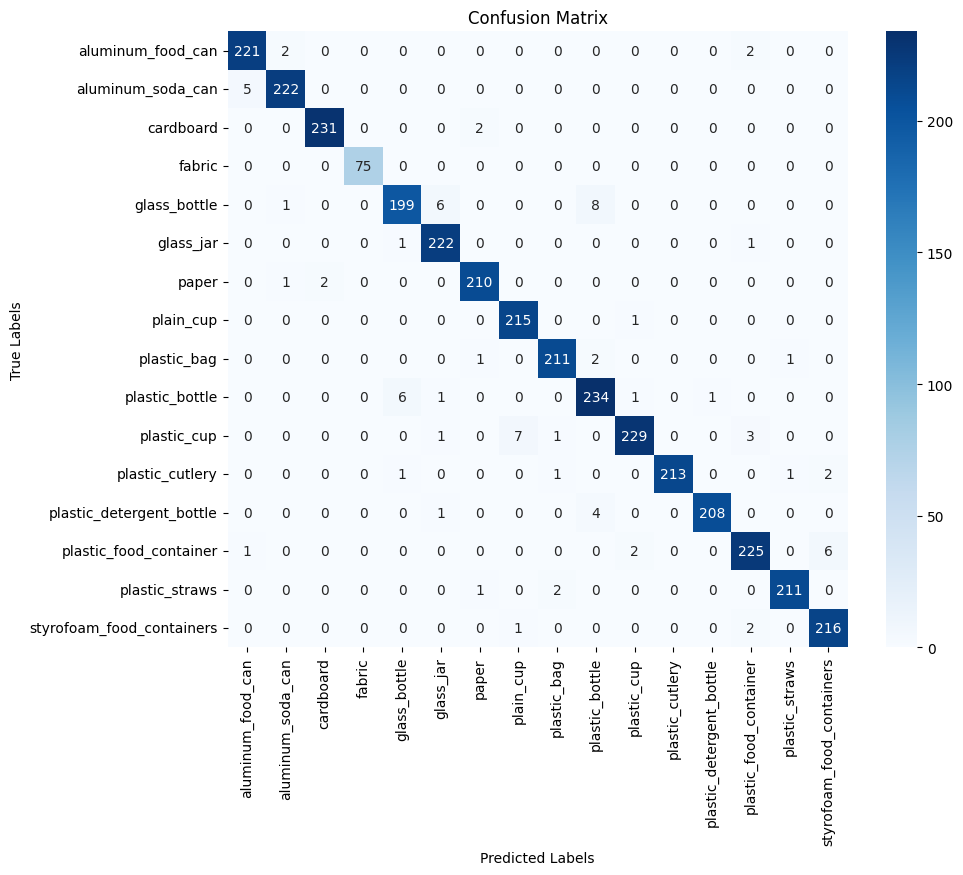

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Evaluate the model on test data
test_loss, test_accuracy = model2V2S.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Step 2: Generate predictions on the test dataset for a detailed report
y_true = []
y_pred = []

# Collect true labels and predicted labels
for images, labels in test_dataset:
    preds = model2V2S.predict(images)
    y_pred.extend(preds.argmax(axis=-1))  # Convert predicted logits to class indices
    y_true.extend(labels.numpy().argmax(axis=-1))

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Step 3: Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)




# Calculate and print precision, recall, and F1 score separately
precision = precision_score(y_true, y_pred, average='weighted')  # Weighted average for multi-class
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### VGG 19 Fine_Tuning

In [ ]:
# Let's take a look to see how many layers are in the base model
base_model = model2vgg.layers[2]
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 150

In [ ]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define a CategoricalCrossentropy loss function.
loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)

# Use accuracy as evaluation metric
metrics=['accuracy']

model2vgg.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2vgg.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 5/15
205/502 ━━━━━━━━━━━━━━━━━━━━ 8:26 2s/step - accuracy: 0.8273 - loss: 0.7418

2024-11-22 19:36:55.231659: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


318/502 ━━━━━━━━━━━━━━━━━━━━ 5:08 2s/step - accuracy: 0.8363 - loss: 0.7134

2024-11-22 19:39:59.293454: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 1014s 2s/step - accuracy: 0.8464 - loss: 0.6800 - val_accuracy: 0.9289 - val_loss: 0.4057
Epoch 6/15
195/502 ━━━━━━━━━━━━━━━━━━━━ 8:42 2s/step - accuracy: 0.9080 - loss: 0.4637

2024-11-22 19:53:07.343584: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


319/502 ━━━━━━━━━━━━━━━━━━━━ 5:09 2s/step - accuracy: 0.9122 - loss: 0.4535

2024-11-22 19:56:34.101950: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 1000s 2s/step - accuracy: 0.9161 - loss: 0.4422 - val_accuracy: 0.9411 - val_loss: 0.3507
Epoch 7/15
198/502 ━━━━━━━━━━━━━━━━━━━━ 8:37 2s/step - accuracy: 0.9411 - loss: 0.3439

2024-11-22 20:09:52.153891: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


309/502 ━━━━━━━━━━━━━━━━━━━━ 5:26 2s/step - accuracy: 0.9432 - loss: 0.3378

2024-11-22 20:12:57.618941: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9453 - loss: 0.3318

2024-11-22 20:18:26.950355: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19269632 bytes after encountering the first element of size 19269632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


502/502 ━━━━━━━━━━━━━━━━━━━━ 989s 2s/step - accuracy: 0.9453 - loss: 0.3318 - val_accuracy: 0.9466 - val_loss: 0.3084
Epoch 8/15
195/502 ━━━━━━━━━━━━━━━━━━━━ 8:40 2s/step - accuracy: 0.9598 - loss: 0.2826

2024-11-22 20:27:07.732070: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


321/502 ━━━━━━━━━━━━━━━━━━━━ 5:04 2s/step - accuracy: 0.9600 - loss: 0.2794

2024-11-22 20:30:37.722926: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9600 - loss: 0.2759

2024-11-22 20:35:47.037748: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19269632 bytes after encountering the first element of size 19269632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


502/502 ━━━━━━━━━━━━━━━━━━━━ 1039s 2s/step - accuracy: 0.9600 - loss: 0.2759 - val_accuracy: 0.9489 - val_loss: 0.2849
Epoch 9/15
217/502 ━━━━━━━━━━━━━━━━━━━━ 8:02 2s/step - accuracy: 0.9663 - loss: 0.2455

2024-11-22 20:44:10.430402: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


333/502 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.9676 - loss: 0.2396

2024-11-22 20:46:58.358499: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 956s 2s/step - accuracy: 0.9685 - loss: 0.2345 - val_accuracy: 0.9487 - val_loss: 0.2803
Epoch 10/15
192/502 ━━━━━━━━━━━━━━━━━━━━ 8:46 2s/step - accuracy: 0.9709 - loss: 0.2044

2024-11-22 20:59:24.312151: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


310/502 ━━━━━━━━━━━━━━━━━━━━ 5:24 2s/step - accuracy: 0.9718 - loss: 0.2022

2024-11-22 21:02:42.386824: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9725 - loss: 0.1987

2024-11-22 21:07:38.409967: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19269632 bytes after encountering the first element of size 19269632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


502/502 ━━━━━━━━━━━━━━━━━━━━ 957s 2s/step - accuracy: 0.9725 - loss: 0.1987 - val_accuracy: 0.9600 - val_loss: 0.2479
Epoch 11/15
197/502 ━━━━━━━━━━━━━━━━━━━━ 8:38 2s/step - accuracy: 0.9784 - loss: 0.1697

2024-11-22 21:15:55.214119: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


331/502 ━━━━━━━━━━━━━━━━━━━━ 4:49 2s/step - accuracy: 0.9788 - loss: 0.1680

2024-11-22 21:19:40.176094: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 961s 2s/step - accuracy: 0.9788 - loss: 0.1671 - val_accuracy: 0.9634 - val_loss: 0.2207
Epoch 12/15
208/502 ━━━━━━━━━━━━━━━━━━━━ 8:17 2s/step - accuracy: 0.9815 - loss: 0.1551

2024-11-22 21:31:48.363571: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


314/502 ━━━━━━━━━━━━━━━━━━━━ 5:18 2s/step - accuracy: 0.9811 - loss: 0.1545

2024-11-22 21:34:48.528849: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 986s 2s/step - accuracy: 0.9809 - loss: 0.1530 - val_accuracy: 0.9634 - val_loss: 0.2091
Epoch 13/15
200/502 ━━━━━━━━━━━━━━━━━━━━ 8:33 2s/step - accuracy: 0.9814 - loss: 0.1357

2024-11-22 21:48:02.908740: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


318/502 ━━━━━━━━━━━━━━━━━━━━ 5:13 2s/step - accuracy: 0.9814 - loss: 0.1364

2024-11-22 21:51:23.570450: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9814 - loss: 0.1363

2024-11-22 21:56:24.761088: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19269632 bytes after encountering the first element of size 19269632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


502/502 ━━━━━━━━━━━━━━━━━━━━ 980s 2s/step - accuracy: 0.9814 - loss: 0.1363 - val_accuracy: 0.9626 - val_loss: 0.1940
Epoch 14/15
224/502 ━━━━━━━━━━━━━━━━━━━━ 7:56 2s/step - accuracy: 0.9803 - loss: 0.1343

2024-11-22 22:05:07.008752: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


322/502 ━━━━━━━━━━━━━━━━━━━━ 5:08 2s/step - accuracy: 0.9805 - loss: 0.1327

2024-11-22 22:07:54.743319: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 994s 2s/step - accuracy: 0.9808 - loss: 0.1305 - val_accuracy: 0.9652 - val_loss: 0.1794
Epoch 15/15
197/502 ━━━━━━━━━━━━━━━━━━━━ 8:44 2s/step - accuracy: 0.9843 - loss: 0.1163

2024-11-22 22:20:55.753984: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


314/502 ━━━━━━━━━━━━━━━━━━━━ 5:22 2s/step - accuracy: 0.9847 - loss: 0.1138

2024-11-22 22:24:16.115700: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 1007s 2s/step - accuracy: 0.9853 - loss: 0.1114 - val_accuracy: 0.9684 - val_loss: 0.1664


107/107 ━━━━━━━━━━━━━━━━━━━━ 92s 856ms/step - accuracy: 0.9732 - loss: 0.1523
Test Loss: 0.16390568017959595
Test Accuracy: 0.96875
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━

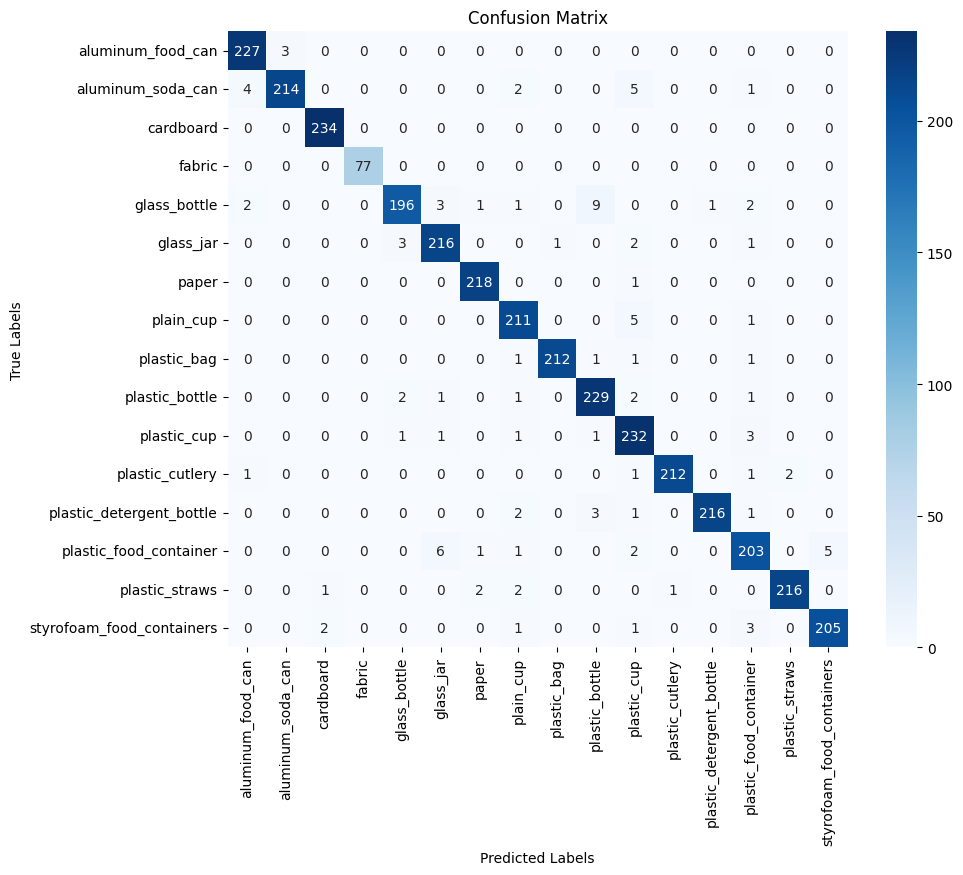

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Evaluate the model on test data
test_loss, test_accuracy = model2vgg.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Step 2: Generate predictions on the test dataset for a detailed report
y_true = []
y_pred = []

# Collect true labels and predicted labels
for images, labels in test_dataset:
    preds = model2vgg.predict(images)
    y_pred.extend(preds.argmax(axis=-1))  # Convert predicted logits to class indices
    y_true.extend(labels.numpy().argmax(axis=-1))

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Calculate and print precision, recall, and F1 score separately
precision = precision_score(y_true, y_pred, average='weighted')  # Weighted average for multi-class
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


# Step 3: Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


RESNET50

We could try fine-tuning the model by re-running the optimizer in the last few layers to improve accuracy.

First, we will unfreeze the base model (resnet50), set a layer to fine-tune from, then re-freeze all the layers before it. We will train it again for another few epochs, and see if the accuracy improved!

In [ ]:
# Let's take a look to see how many layers are in the base model
base_model = model2.layers[2]
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 150

In [ ]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define a CategoricalCrossentropy loss function.
loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)

# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 5/15


193/502 ━━━━━━━━━━━━━━━━━━━━ 8:45 2s/step - accuracy: 0.8264 - loss: 0.7660

2024-11-22 22:42:51.915880: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


308/502 ━━━━━━━━━━━━━━━━━━━━ 5:30 2s/step - accuracy: 0.8353 - loss: 0.7341

2024-11-22 22:46:07.675253: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 968s 2s/step - accuracy: 0.8466 - loss: 0.6946 - val_accuracy: 0.9228 - val_loss: 0.4266
Epoch 6/15
203/502 ━━━━━━━━━━━━━━━━━━━━ 8:26 2s/step - accuracy: 0.9210 - loss: 0.4468

2024-11-22 22:59:29.574419: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


331/502 ━━━━━━━━━━━━━━━━━━━━ 4:49 2s/step - accuracy: 0.9215 - loss: 0.4414

2024-11-22 23:03:06.813088: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 1023s 2s/step - accuracy: 0.9228 - loss: 0.4332 - val_accuracy: 0.9315 - val_loss: 0.3835
Epoch 7/15
199/502 ━━━━━━━━━━━━━━━━━━━━ 8:35 2s/step - accuracy: 0.9452 - loss: 0.3377

2024-11-22 23:15:49.458921: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


315/502 ━━━━━━━━━━━━━━━━━━━━ 5:18 2s/step - accuracy: 0.9450 - loss: 0.3360

2024-11-22 23:19:06.549241: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 986s 2s/step - accuracy: 0.9457 - loss: 0.3319 - val_accuracy: 0.9510 - val_loss: 0.3133
Epoch 8/15
218/502 ━━━━━━━━━━━━━━━━━━━━ 8:01 2s/step - accuracy: 0.9605 - loss: 0.2812

2024-11-22 23:32:46.187412: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


319/502 ━━━━━━━━━━━━━━━━━━━━ 5:10 2s/step - accuracy: 0.9606 - loss: 0.2790

2024-11-22 23:35:37.201926: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 984s 2s/step - accuracy: 0.9608 - loss: 0.2752 - val_accuracy: 0.9437 - val_loss: 0.3135
Epoch 9/15
204/502 ━━━━━━━━━━━━━━━━━━━━ 8:26 2s/step - accuracy: 0.9672 - loss: 0.2391

2024-11-22 23:48:47.129869: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


317/502 ━━━━━━━━━━━━━━━━━━━━ 5:14 2s/step - accuracy: 0.9682 - loss: 0.2346

2024-11-22 23:51:59.311128: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 985s 2s/step - accuracy: 0.9689 - loss: 0.2304 - val_accuracy: 0.9527 - val_loss: 0.2788
Epoch 10/15
185/502 ━━━━━━━━━━━━━━━━━━━━ 9:05 2s/step - accuracy: 0.9752 - loss: 0.2061

2024-11-23 00:05:41.456216: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


313/502 ━━━━━━━━━━━━━━━━━━━━ 5:32 2s/step - accuracy: 0.9743 - loss: 0.2052

2024-11-23 00:09:33.481726: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 1084s 2s/step - accuracy: 0.9738 - loss: 0.2036 - val_accuracy: 0.9492 - val_loss: 0.2596
Epoch 11/15
205/502 ━━━━━━━━━━━━━━━━━━━━ 8:55 2s/step - accuracy: 0.9783 - loss: 0.1791

2024-11-23 00:23:39.252900: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


318/502 ━━━━━━━━━━━━━━━━━━━━ 5:26 2s/step - accuracy: 0.9790 - loss: 0.1758

2024-11-23 00:26:53.674831: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 1011s 2s/step - accuracy: 0.9793 - loss: 0.1726 - val_accuracy: 0.9620 - val_loss: 0.2116
Epoch 12/15
209/502 ━━━━━━━━━━━━━━━━━━━━ 8:22 2s/step - accuracy: 0.9831 - loss: 0.1491

2024-11-23 00:40:19.213198: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


314/502 ━━━━━━━━━━━━━━━━━━━━ 5:22 2s/step - accuracy: 0.9833 - loss: 0.1472

2024-11-23 00:43:19.667344: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 995s 2s/step - accuracy: 0.9830 - loss: 0.1464 - val_accuracy: 0.9626 - val_loss: 0.2164
Epoch 13/15
201/502 ━━━━━━━━━━━━━━━━━━━━ 8:37 2s/step - accuracy: 0.9824 - loss: 0.1435

2024-11-23 00:56:41.414324: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


312/502 ━━━━━━━━━━━━━━━━━━━━ 5:26 2s/step - accuracy: 0.9826 - loss: 0.1411

2024-11-23 00:59:51.752986: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 997s 2s/step - accuracy: 0.9828 - loss: 0.1381 - val_accuracy: 0.9594 - val_loss: 0.2021
Epoch 14/15
189/502 ━━━━━━━━━━━━━━━━━━━━ 8:55 2s/step - accuracy: 0.9855 - loss: 0.1236

2024-11-23 01:12:55.960948: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


332/502 ━━━━━━━━━━━━━━━━━━━━ 4:51 2s/step - accuracy: 0.9849 - loss: 0.1220

2024-11-23 01:17:00.768373: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 993s 2s/step - accuracy: 0.9848 - loss: 0.1208 - val_accuracy: 0.9603 - val_loss: 0.1927
Epoch 15/15
216/502 ━━━━━━━━━━━━━━━━━━━━ 8:10 2s/step - accuracy: 0.9832 - loss: 0.1136

2024-11-23 01:31:04.857498: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


306/502 ━━━━━━━━━━━━━━━━━━━━ 5:36 2s/step - accuracy: 0.9839 - loss: 0.1122

2024-11-23 01:33:38.805008: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


502/502 ━━━━━━━━━━━━━━━━━━━━ 1044s 2s/step - accuracy: 0.9846 - loss: 0.1105 - val_accuracy: 0.9655 - val_loss: 0.1903


### 4.1 some predictions after fine-tuning

In [ ]:
# plt.figure(figsize=(10, 10))
# for images, labels in validation_dataset.take(1):
#     # Predict the labels for the batch of images
#     predictions = model2B0.predict(images)
#     predicted_labels = tf.argmax(predictions, axis=1)

#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))

#         # Check if labels are one-hot encoded or integer
#         if len(labels[i].shape) == 0:  # If shape is scalar, it's an integer label
#             true_label_index = labels[i].numpy()
#         else:
#             true_label_index = tf.argmax(labels[i]).numpy()

#         predicted_label_index = predicted_labels[i].numpy()

#         # Get the corresponding label names
#         true_label_name = class_names[true_label_index]
#         predicted_label_name = class_names[predicted_label_index]

#         plt.title(f'True: {true_label_name}\nPred: {predicted_label_name}')
#         plt.axis("off")

# plt.show()


### 4.2 Confusion Matrix and Classification Report after fine-tuning  

107/107 ━━━━━━━━━━━━━━━━━━━━ 86s 803ms/step - accuracy: 0.9664 - loss: 0.1710
Test Loss: 0.1833430379629135
Test Accuracy: 0.9634929895401001
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


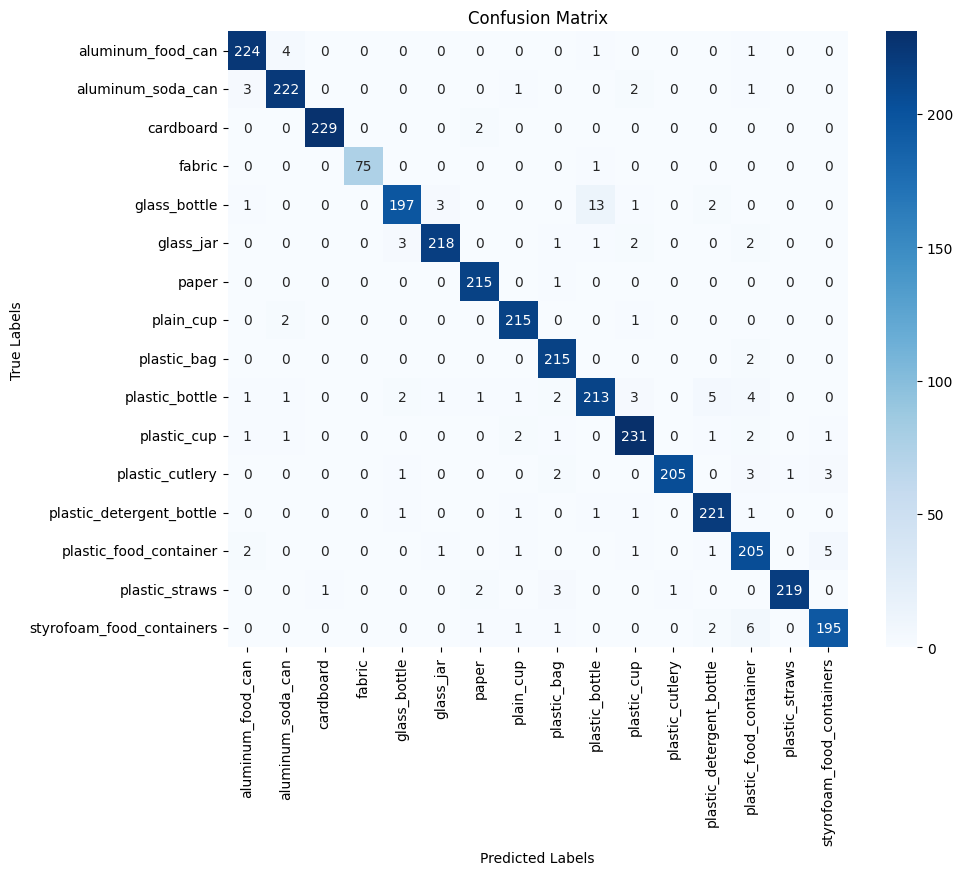

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Evaluate the model on test data
test_loss, test_accuracy = model2.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Step 2: Generate predictions on the test dataset for a detailed report
y_true = []
y_pred = []

# Collect true labels and predicted labels
for images, labels in test_dataset:
    preds = model2.predict(images)
    y_pred.extend(np.argmax(preds, axis=-1))  # Convert predicted logits to class indices
    y_true.extend(np.argmax(labels.numpy(), axis=-1))  # Assuming labels are one-hot encoded


# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))  # Replace `class_names` with your label names

# Calculate and print precision, recall, and F1 score separately
precision = precision_score(y_true, y_pred, average='weighted')  # Weighted average for multi-class
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


# Step 3: Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



Model Accuracy Comparison:
                Train Accuracy  Validation Accuracy
EfficientNetB0          0.9514               0.9603
VGG19                   0.9853               0.9684
ResNet50                0.9846               0.9655


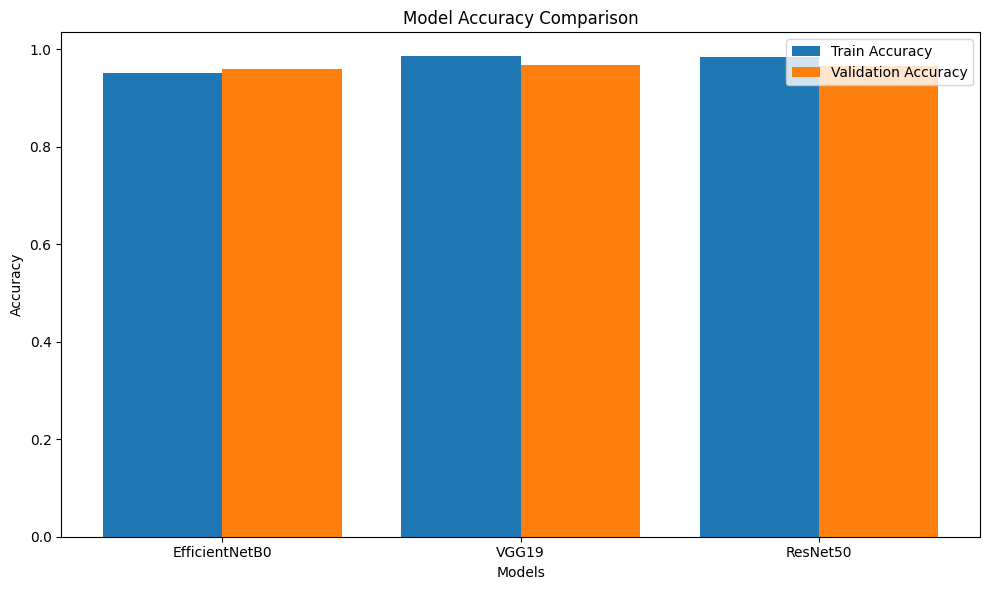

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extracting final accuracies from the training logs
results = {
    "EfficientNetB0": {
        "train_accuracy": 0.9514,  # Replace with the final train accuracy from the logs
        "val_accuracy": 0.9603    # Replace with the final validation accuracy from the logs
    },
    "VGG19": {
        "train_accuracy": 0.9853,  # Replace with the final train accuracy from the logs
        "val_accuracy": 0.9684    # Replace with the final validation accuracy from the logs
    },
    "ResNet50": {
        "train_accuracy": 0.9846,  # Replace with the final train accuracy from the logs
        "val_accuracy": 0.9655    # Replace with the final validation accuracy from the logs
    }
}

# Create a DataFrame for tabular comparison
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["Train Accuracy", "Validation Accuracy"]

# Display the DataFrame for visual comparison
print("\nModel Accuracy Comparison:")
print(df)

# Plotting the results
plt.figure(figsize=(10, 6))
x = range(len(results))
models = list(results.keys())
train_accuracies = [results[model]['train_accuracy'] for model in models]
val_accuracies = [results[model]['val_accuracy'] for model in models]

# Bar chart
plt.bar(x, train_accuracies, width=0.4, label='Train Accuracy', align='center')
plt.bar([i + 0.4 for i in x], val_accuracies, width=0.4, label='Validation Accuracy', align='center')

# Customize the plot
plt.xticks([i + 0.2 for i in x], models)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
print(tf.keras.__version__)

3.6.0


### Save Best Model

In [ ]:
model2V2S.save('/content/drive/MyDrive/materials dataset/V2S.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


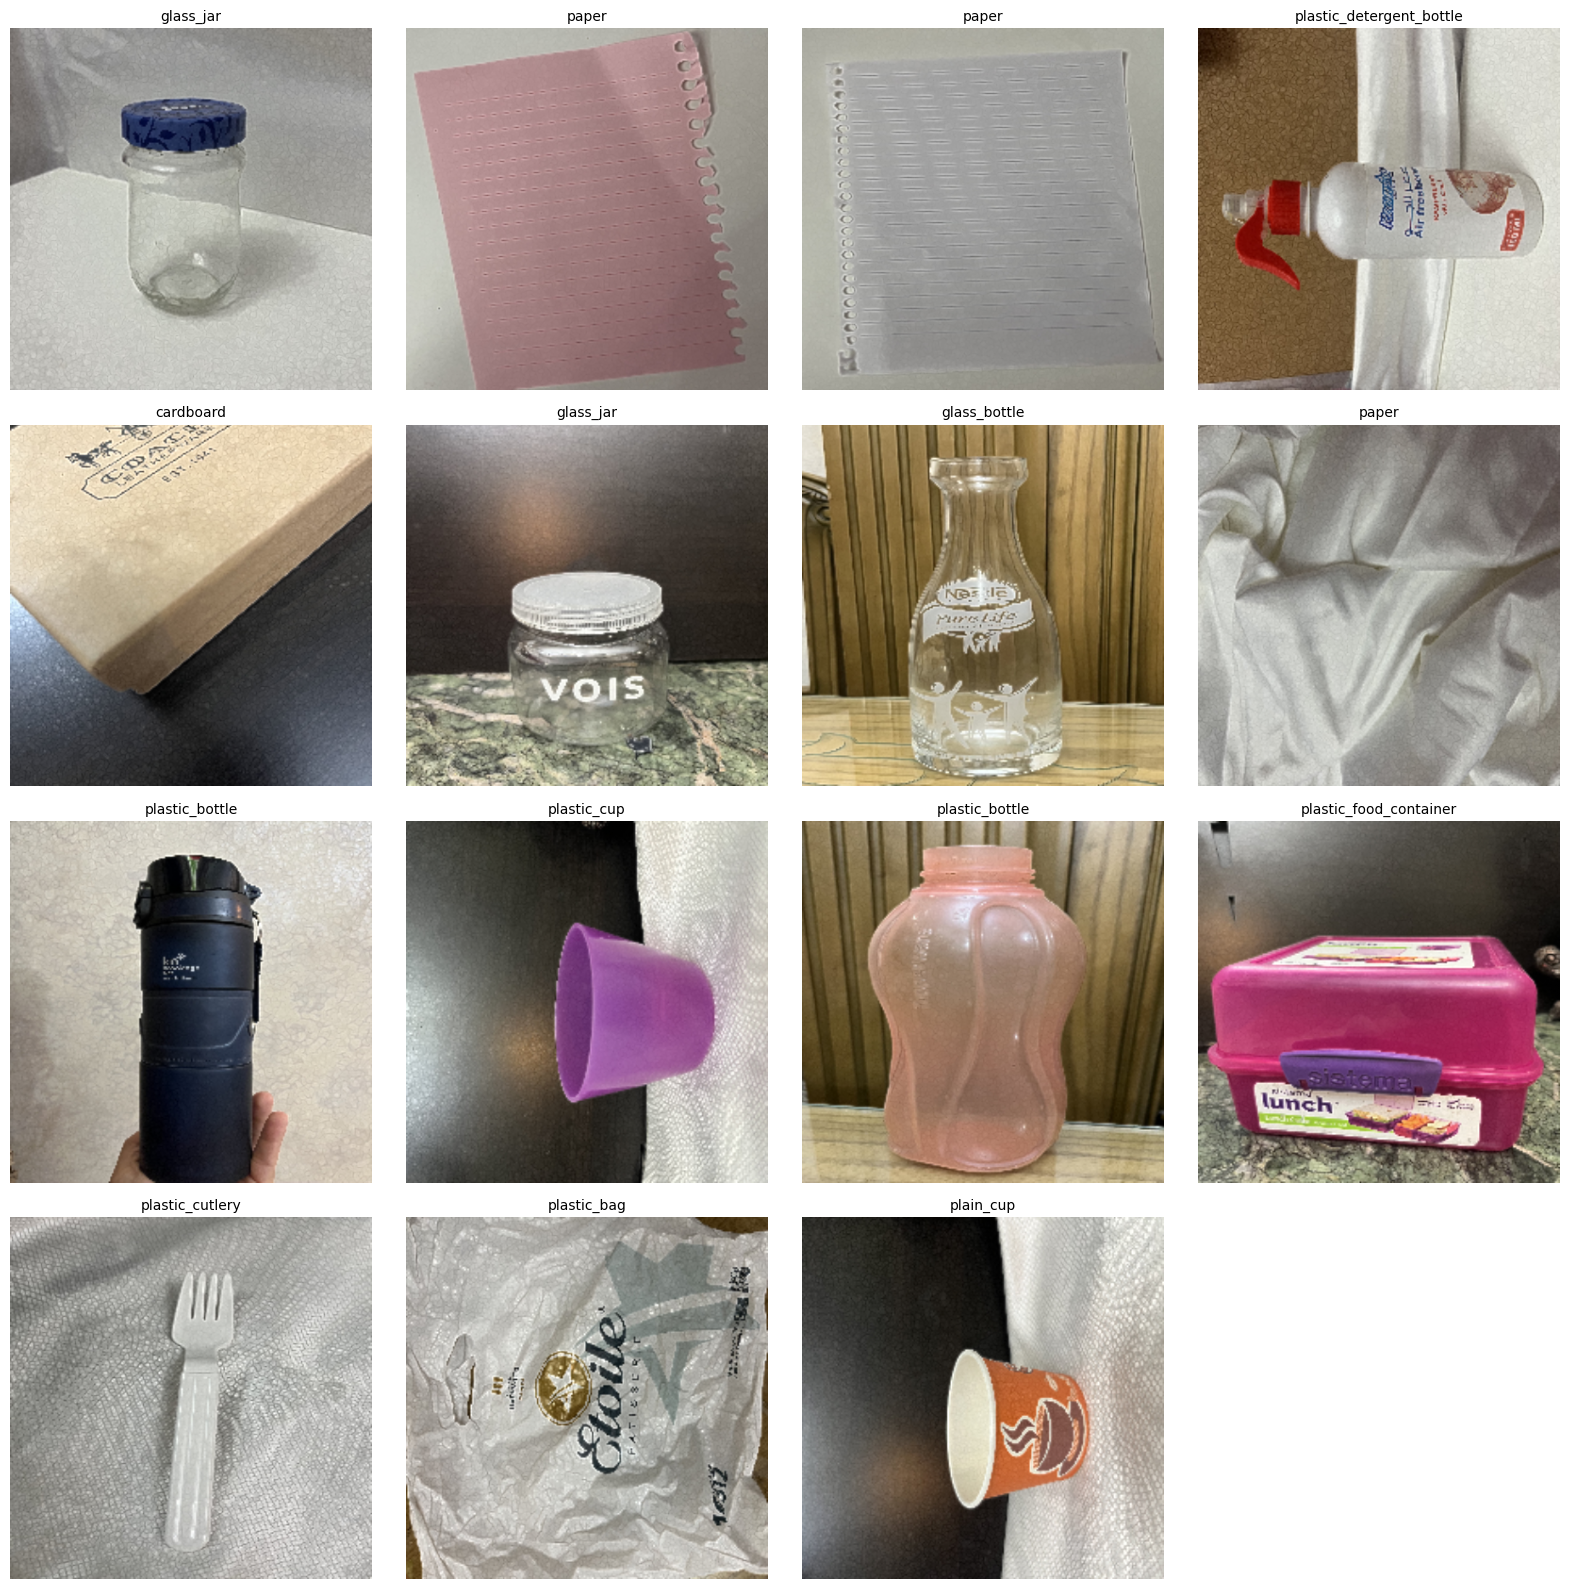

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
# Load the saved model
model_path = "/content/drive/MyDrive/materials dataset/V2S.keras"
model = tf.keras.models.load_model(model_path)

# Class names
class_names = [
    'aluminum_food_can', 'aluminum_soda_can', 'cardboard', 'fabric', 'glass_bottle', 'glass_jar',
    'paper', 'plain_cup', 'plastic_bag', 'plastic_bottle', 'plastic_cup', 'plastic_cutlery',
    'plastic_detergent_bottle', 'plastic_food_container', 'plastic_straws', 'styrofoam_food_containers'
]


def detect_edges(image):
    """
    Preprocess a TensorFlow image tensor to enhance texture while preserving color for classification.

    Args:
        image (tf.Tensor or np.ndarray): Input image tensor (height, width, channels) or NumPy array.

    Returns:
        tf.Tensor: Preprocessed color image tensor with additional texture and edge information.
    """
    # Convert TensorFlow tensor to NumPy array for OpenCV processing
    image_np = image.numpy() if isinstance(image, tf.Tensor) else image
    image_np = np.array(image_np, dtype=np.uint8)

    # Ensure image is in BGR format for OpenCV
    if len(image_np.shape) == 3 and image_np.shape[2] == 3:  # RGB image
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Resize to consistent size (224x224)
    img_resized = cv2.resize(image_np, (384, 384))

    # Split channels for color contrast enhancement
    b, g, r = cv2.split(img_resized)

    # Apply histogram equalization on each channel
    b_eq = cv2.equalizeHist(b)
    g_eq = cv2.equalizeHist(g)
    r_eq = cv2.equalizeHist(r)

    # Merge channels back into a single image
    img_eq = cv2.merge((b_eq, g_eq, r_eq))

    # Convert to grayscale for edge detection
    gray = cv2.cvtColor(img_eq, cv2.COLOR_BGR2GRAY)

    # Use Sobel filter to extract edges
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    sobel_xy = cv2.Sobel(gray, cv2.CV_64F, 1, 1, ksize=5)
    sobel_combined = cv2.magnitude(sobel_x, sobel_y,sobel_xy)

    # Normalize the Sobel result
    sobel_norm = cv2.normalize(sobel_combined, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Use Sobel edges as an alpha mask for texture enhancement
    sobel_alpha = cv2.merge((sobel_norm, sobel_norm, sobel_norm))

    # Blend edges as a subtle overlay
    # Avoid modifying the brightness of the original image
    final_img = cv2.addWeighted(img_resized, 1.0, sobel_alpha, 0.2, 0)  # Dominant original image

    # Convert back to RGB for TensorFlow compatibility
    final_img_rgb = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)

    return tf.convert_to_tensor(final_img_rgb, dtype=tf.uint8)


# Image preprocessing function
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array= detect_edges(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array



def predict_images_in_grid(folder_path, grid_size=(6, 7)):
    """
    Predict and display a grid of images with their predictions.

    Args:
        folder_path (str): Path to the folder containing images.
        grid_size (tuple): Number of rows and columns in the grid.
    """
    # Collect valid images and their predictions
    images = []
    predictions = []

    for img_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, img_name)
        try:
            # Check if the image is valid
            with Image.open(file_path) as im:
                im.verify()  # Verify image integrity

            # Preprocess and predict
            img_array = preprocess_image(file_path)
            logits = model.predict(img_array)[0]
            probabilities = tf.nn.softmax(logits).numpy()
            predicted_class = np.argmax(probabilities)
            predicted_label = class_names[predicted_class]

            # Store the image and prediction
            images.append(np.squeeze(img_array, axis=0))  # Remove batch dimension
            predictions.append(predicted_label)
        except (IOError, SyntaxError) as e:
            print(f"Skipping invalid or corrupted image: {file_path}")
            continue

      # Plot the images and predictions in a grid
    total_images = len(images)


    import math
    rows = math.ceil(total_images / 4)
    cols = min(total_images, 4)

    # Plot the images and predictions in a grid
    fig, axes = plt.subplots(rows, cols, figsize=(4 * 4, rows * 4))
    axes = axes.flatten() if total_images > 1 else [axes]

    for i, (img, label) in enumerate(zip(images, predictions)):
        ax = axes[i]
        ax.imshow(img / 255.0)  # Normalize to [0,1] for display
        ax.axis('off')
        ax.set_title(label, fontsize=10)

    # Turn off unused axes
    for i in range(total_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



# Folder path to test images
folder_path = "/content/drive/MyDrive/hngrab/test_images"

# Predict and display all images in a grid
predict_images_in_grid(folder_path, grid_size=(6, 7))
